## Merge CRSP and Compustat
The purpose of this file is to demnostrate how to merge CRSP and Compustat to map PERMNO-GVKEY pairs without CRSP-Compustat Merge table (CCM).
However, you should keep in mind that CCM will always give you more complete match than using CUSIP. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

pd.options.display.width = 180
sns.set()

### Read required data
We need the following data:
1. CRSP stock name history file
2. Compustat stock name history file
3. CRSP monthly stock file

For first and second dataset, you can retrieve via WRDS cloud. The source is **crsp.msenames** and **comp.security**.

### CRSP CUSIP list

In [2]:
stocknames = pd.read_csv('~/data/wrds/raw/stocknames.txt',sep='\t')
stocknames.columns = stocknames.columns.map(str.lower)
len(stocknames)
stocknames_1 = stocknames[(stocknames['cusip'].notnull())&(stocknames['shrcd'].isin([10,11]))&(stocknames['exchcd'].isin([1,2,3]))].copy()
crsp_cusip = stocknames_1.drop_duplicates(subset='cusip')[['permno','cusip']].sort_values('permno').reset_index(drop=True)

### Compustat CUSIP list

In [3]:
security = pd.read_csv('~/data/wrds/raw/security.txt',sep='\t')
security.columns = security.columns.map(str.lower)
security_1 = security[security['cusip'].notnull()].copy()
security_1['cusip'] = security_1['cusip'].apply(lambda x: str(x[:8]))
comp_cusip = security_1.drop_duplicates(subset='cusip')[['gvkey','cusip']].sort_values('gvkey').reset_index(drop=True)

### PERMNO-GVKEY link using CUSIP 

In [4]:
crsp_comp_link_all = crsp_cusip.merge(comp_cusip,how='left',on='cusip')
crsp_comp_link = crsp_cusip.merge(comp_cusip,how='inner',on='cusip')

### Check the percent of match over time

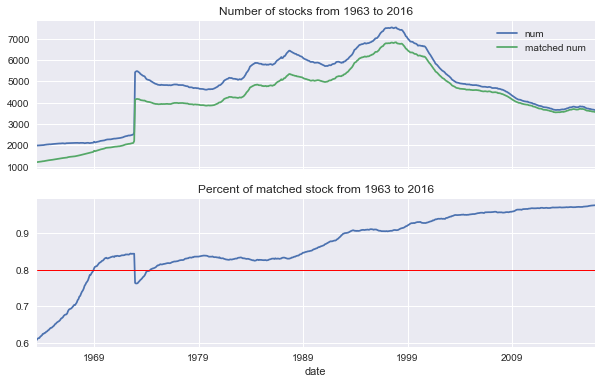

In [5]:
# CRSP monthly file: this file (msf.h5) already deletes duplicates and keeps only stocks listing in NYSE/NASDAQ/AMEX
msf = pd.read_hdf('/users/ml/data/clean/wrds/msf.h5', 'msf', columns=['permno','permco','cusip','date','ncusip','comnam','ticker','shrcd','exchcd'])
# Keep common shares
msf_1 = msf[msf['shrcd'].isin([10,11])].copy()
msf_1['yrm'] = (msf_1['date']/100).astype('int')
link_ts_all = msf_1.merge(crsp_comp_link_all[['permno','gvkey']],how='inner',on='permno')
link_ts_all_1 = link_ts_all.groupby('yrm')['permno'].count().to_frame('num').sort_index()
link_ts = msf_1.merge(crsp_comp_link[['permno','gvkey']],how='inner',on='permno')
link_ts_1 = link_ts.groupby('yrm')['permno'].count().to_frame('matched num').sort_index()
link_percent = link_ts_1.join(link_ts_all_1).sort_index()
link_percent = link_percent[link_percent.index>=196307]
link_percent['percent of matched stock'] = link_percent['matched num'] / link_percent['num']
link_percent.index = pd.to_datetime(link_percent.index,format='%Y%m')
link_percent.index.name = 'date'
plt.close('all')
fig1,(ax1,ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True)
link_percent[['num','matched num']].plot(ax=ax1)
ax1.set_title('Number of stocks from 1963 to 2016')
link_percent['percent of matched stock'].plot(ax=ax2)
ax2.set_title('Percent of matched stock from 1963 to 2016')
ax2.axhline(0.8,color='r',linewidth=1)
plt.show()

The matched stocks from CRSP and Compustat using CUSIP are not complete, but the percent of matched is getting close to 100% in the past ten years. And most of periods can reach more than 80%.